# **GETAROUND - PRÉDICTIONS DES PRIX DE LOCATION (MACHINE LEARNING)**
### **BLOC 06 : DÉPLOIEMENT**

---

### Importations & Configuration

In [10]:
# Manipulation de données
import pandas as pd
import numpy as np
import os

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 

# Feature engineering et prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Métriques
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Sauvegardes
import joblib

# Ignorer les avertissements (warnings) inutiles
import warnings
warnings.filterwarnings('ignore')

---

## **PARTIE 1 |  ANALYSE EXPLORATOIRE INITIALE ET NETTOYAGE DES DONNÉES**

### 1. Chargement et aperçu général

In [4]:
# Chargement du dataset
df = pd.read_csv(r"get_around_pricing_project.csv")

# Aperçu des premières lignes
df.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [5]:
# Informations générales
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

In [6]:
#Statistiques basiques
print(df.describe(include='object'))
print("-" * 90)
df.describe()

       model_key    fuel paint_color car_type
count       4843    4843        4843     4843
unique        28       4          10        8
top      Citroën  diesel       black   estate
freq         969    4641        1633     1606
------------------------------------------------------------------------------------------


,Unnamed: 0,mileage,engine_power,rental_price_per_day
count,4843.000000,4.843000e+03,4843.00000,4843.000000
mean,2421.000000,1.409628e+05,128.98823,121.214536
std,1398.198007,6.019674e+04,38.99336,33.568268
min,0.000000,-6.400000e+01,0.00000,10.000000
25%,1210.500000,1.029135e+05,100.00000,104.000000
50%,2421.000000,1.410800e+05,120.00000,119.000000
75%,3631.500000,1.751955e+05,135.00000,136.000000
max,4842.000000,1.000376e+06,423.00000,422.000000


### 2. Nettoyage des données

In [7]:
# Suppression de la colonne inutile (si elle existe)
df = df.drop('Unnamed: 0', axis=1)

# Filtrage des valeurs aberrantes évidentes
# mileage négatif : le kilométrage minimum est -64 (impossible).
# engine_power à 0 : une voiture avec 0 cheval-vapeur ne roule pas.
df = df[df['mileage'] >= 0]
df = df[df['engine_power'] > 0]

# Vérification après nettoyage
print(f"Dimensions après premier nettoyage : {df.shape}")
display(df.describe())

Dimensions après premier nettoyage : (4841, 14)


,mileage,engine_power,rental_price_per_day
count,4.841000e+03,4841.000000,4841.000000
mean,1.410042e+05,128.994010,121.185705
std,6.016901e+04,38.930253,33.502751
min,4.760000e+02,25.000000,10.000000
25%,1.030340e+05,100.000000,104.000000
50%,1.410890e+05,120.000000,119.000000
75%,1.752170e+05,135.000000,136.000000
max,1.000376e+06,423.000000,422.000000


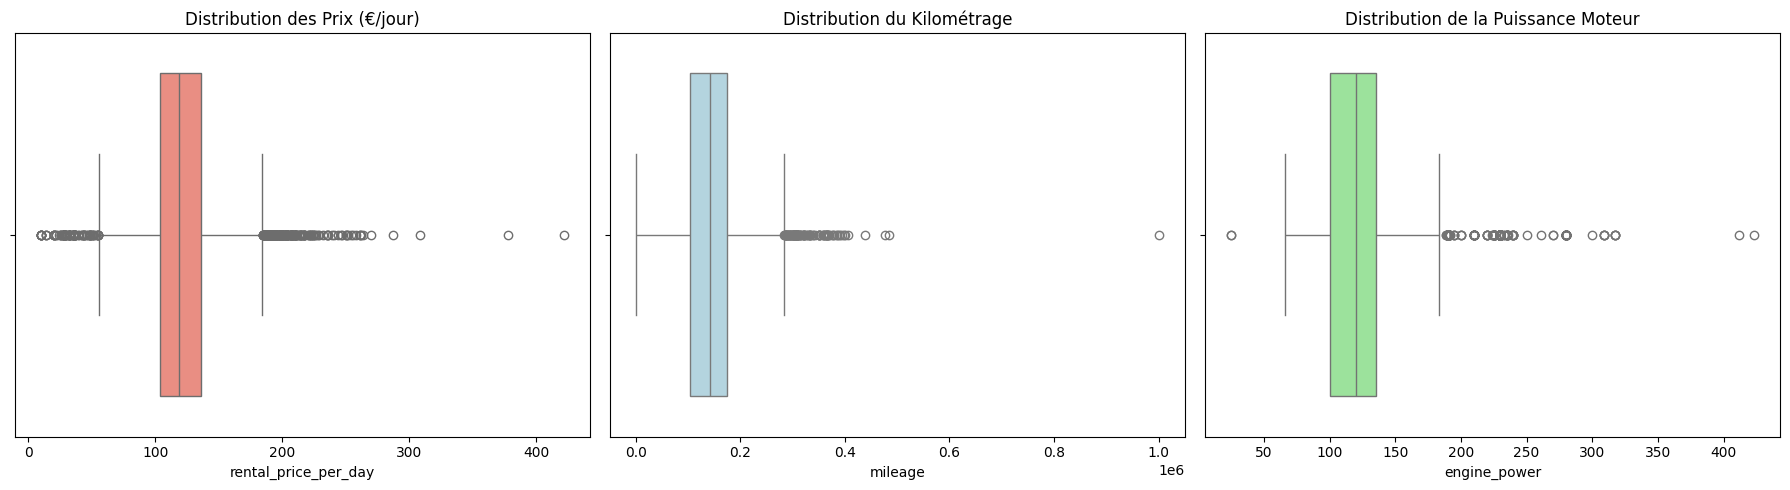

Zoom sur les valeurs les plus élevées :
------------------------------
Prix max : 422 €
Kilométrage max : 1000376 km
Puissance max : 423 ch


In [11]:
# Visualisation des outliers pour décider des suppressions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot des Prix
sns.boxplot(data=df, x='rental_price_per_day', color='salmon', ax=axes[0])
axes[0].set_title("Distribution des Prix (€/jour)")

# Boxplot du Kilométrage
sns.boxplot(data=df, x='mileage', color='lightblue', ax=axes[1])
axes[1].set_title("Distribution du Kilométrage")

# Boxplot de la Puissance
sns.boxplot(data=df, x='engine_power', color='lightgreen', ax=axes[2])
axes[2].set_title("Distribution de la Puissance Moteur")

plt.tight_layout()
plt.show()

# Affichage des valeurs extrêmes pour aider à la décision
print("Zoom sur les valeurs les plus élevées :")
print("-" * 30)
print(f"Prix max : {df['rental_price_per_day'].max()} €")
print(f"Kilométrage max : {df['mileage'].max()} km")
print(f"Puissance max : {df['engine_power'].max()} ch")

In [12]:
# Nettoyage des outliers

print(f"Dimensions avant filtrage : {df.shape}")

df = df[df['mileage'] < 600000]
df = df[df['rental_price_per_day'] < 300]
# df = df[df['engine_power'] < 350]  # à tester dans un second temps

print(f"Dimensions après filtrage : {df.shape}")

Dimensions avant filtrage : (4841, 14)
Dimensions après filtrage : (4837, 14)


---

## **PARTIE 2 | PRÉPROCESSING**

In [13]:
# Séparation des features (X) et de la target (y)
target_name = 'rental_price_per_day'
X = df.drop(target_name, axis=1)
y = df[target_name]

# Identification des types de colonnes
numeric_features = ['mileage', 'engine_power']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Variables numériques : {numeric_features}")
print(f"Variables catégorielles : {categorical_features}")

# Création des Transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Création du Preprocessor (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Division du dataset (Train / Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Préprocessing terminé !")

Variables numériques : ['mileage', 'engine_power']
Variables catégorielles : ['model_key', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
Préprocessing terminé !


---

## **PARTIE 3 | MODÉLISATION (BASELINE)**

In [15]:
# Pipeline complet : Preprocessing -> Modèle
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraînement
print("Entraînement du modèle (Linear Regression)...")
model.fit(X_train, y_train)

# Prédiction
print("Prédictions sur le jeu de test...")
y_pred = model.predict(X_test)

# Évaluation
print("-" * 30)
print("RÉSULTATS (Baseline) :")
print(f"R2 Score : {r2_score(y_test, y_pred):.4f}")
# CORRECTION ICI : On utilise np.sqrt()
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} €")

Entraînement du modèle (Linear Regression)...
Prédictions sur le jeu de test...
------------------------------
RÉSULTATS (Baseline) :
R2 Score : 0.6984
RMSE : 18.32 €


---

## **PARTIE 4 | OPTIMISATION DU MODÉLE**

### 1. Comparaison des modèles avec Cross-Validation (RandomForest, BaggingRegressor et AdaBoostRegressor)

In [16]:
# Liste pour stocker les résultats
results_list = []

# Dictionnaire des modèles et de leurs hyperparamètres à tester
models_to_test = [
    {
        'name': 'Ridge (Régularisation L2)',
        'model': Ridge(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'Lasso (Régularisation L1)',
        'model': Lasso(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [10, 20, None]
        }
    },
    {
        'name': 'Bagging Regressor',
        'model': BaggingRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [10, 50]
        }
    },
    {
        'name': 'AdaBoost',
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100],
            'regressor__learning_rate': [0.01, 0.1, 1.0]
        }
    }
]

print("Début de la comparaison des modèles avec Cross-Validation...")
print("-" * 60)

best_overall_model = None
best_overall_score = -np.inf

# --- BOUCLE D'ENTRAÎNEMENT ---
for m in models_to_test:
    print(f"Entraînement de : {m['name']}...")
    
    # Création du Pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', m['model'])
    ])
    
    # Configuration du GridSearch
    grid = GridSearchCV(pipe, m['params'], cv=5, scoring='r2', n_jobs=-1)
    
    # Entraînement
    grid.fit(X_train, y_train)
    
    # Prédiction
    y_pred = grid.predict(X_test)
    
    # Scores
    r2 = r2_score(y_test, y_pred)
    
    # CORRECTION ICI : np.sqrt()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Sauvegarde du meilleur modèle global
    if r2 > best_overall_score:
        best_overall_score = r2
        best_overall_model = grid.best_estimator_
    
    # Ajout aux résultats
    results_list.append({
        'Modèle': m['name'],
        'Meilleurs Paramètres': str(grid.best_params_),
        'R2 Score (Test)': r2,
        'RMSE (Test)': rmse
    })

print("-" * 60)
print("Comparaison terminée !")

Début de la comparaison des modèles avec Cross-Validation...
------------------------------------------------------------
Entraînement de : Ridge (Régularisation L2)...
Entraînement de : Lasso (Régularisation L1)...
Entraînement de : Random Forest...
Entraînement de : Bagging Regressor...
Entraînement de : AdaBoost...
------------------------------------------------------------
Comparaison terminée !


### 2. Tableau récapitulatif

In [17]:
df_results = pd.DataFrame(results_list)
df_results = df_results.sort_values(by='R2 Score (Test)', ascending=False) # Le meilleur en haut

print("\nCLASSEMENT DES MODÈLES :")
display(df_results)


CLASSEMENT DES MODÈLES :


,Modèle,Meilleurs Paramètres,R2 Score (Test),RMSE (Test)
2,Random Forest,"{'regressor__max_depth': 20, 'regressor__n_est...",0.771220,15.954197
3,Bagging Regressor,{'regressor__n_estimators': 50},0.770722,15.971564
0,Ridge (Régularisation L2),{'regressor__alpha': 1.0},0.702621,18.189513
1,Lasso (Régularisation L1),{'regressor__alpha': 0.01},0.701353,18.228245
4,AdaBoost,"{'regressor__learning_rate': 0.1, 'regressor__...",0.599336,21.113294


### 3. Sauvegarde du meilleur modèle trouvé par le GridSearch

In [18]:
filename = 'model.joblib'
joblib.dump(best_overall_model, filename)

print(f"Le meilleur modèle ({df_results.iloc[0]['Modèle']}) a été sauvegardé dans '{filename}'.")
print(f"Performance R2 : {best_overall_score:.4f}")

Le meilleur modèle (Random Forest) a été sauvegardé dans 'model.joblib'.
Performance R2 : 0.7712
